# Linear Classification

This tutorial is based on [CS231n Winter 2016: Lecture 3: Linear Classification and Optimization](https://cs231n.github.io/linear-classify/), [video](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC).


### Linear classifier.

$$ f(\mathbf{x},\mathbf{W},\mathbf{b})= \mathbf{W}\mathbf{x}+\mathbf{b},$$

where $\mathbf{x} \in \mathbb{R}^{D \times 1}$, $\mathbf{W} \in \mathbb{R}^{K \times D}$ and $\mathbf{b} \in \mathbb{R}^{K \times 1}$. $D$ denotes the number of dimensions and $K$ denotes the number of classes.

In [1]:
import numpy as np
from sklearn.datasets import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
np.random.seed(0)

D=2 # num of input dim
N=4 # num of data
K=3 # num of classes

X=np.random.randn(D,N) # a column vector -including biases =1.
W=np.random.randn(K,D) # 
b=np.random.randn(K,1) # 
y=np.random.randint(K, size=N)

In [2]:
def f(W,x,b=0):
    return W.dot(x)+b

# Maximum Margin Classifier

Given $(\mathbf{x}_i,y_i)$ where $\mathbf{x} \in \mathbb{R}^{D \times 1}$ is an input and $y_i$ is the integer label indicating the true class. Predictions/Scores are computed as 

$$\mathbf{s}_i=f(\mathbf{x}_i,\mathbf{W})=\mathbf{W}\mathbf{x}_i +\mathbf{b}$$ where $\mathbf{s}_i \in \mathbb{R}^{k \times 1}$ denotes scores for each class. The multiclass maximum largin (also called SVM) loss has the form:

$$ L_i = \Sigma_{j \not = y_i} max(0, s_j - s_{y_i} +1)$$ where $s_j$ notes the score of the j.th class / $j.th$ item in the $s$ wherase $s_{y_i}$ denotes the score of the correct class.

Finally, the cost of $W$ with respect to the SVM loss function over all datapoints computed as

$$ L = \frac{1}{n} \Sigma_{i=1} ^n \Sigma_{j \not = y_i} max(0, s_j - s_{y_i} +1)$$

where $n$ denotes the number of data points. Note that $max(0,-)$ function is also known as the **hingle loss**.


# Softmax  classifier - Multinomial Logistic Regression


### Softmax function

The softmax function is a vector valued function that is defined as $S(\mathbf{a}):\mathbb{R}^{K}\rightarrow \mathbb{R}^{K}$:


$$
S(\mathbf{a}):\begin{bmatrix}
a_1\\
a_2\\
\cdots\\
a_K
\end{bmatrix}
\rightarrow
\begin{bmatrix}
S_1\\
S_2\\
\cdots\\
S_K
\end{bmatrix}$$


$$ S_j=\frac{e^{a_j}}{\sum_{k=1}^{K}e^{a_k}} \qquad \forall j \in 1..K $$

### Softmax Classifier

The softmax classifier considers the output of $f(\mathbf{x}_i,\mathbf{W})$ as **unnormalized log probabilities of the classes**. 


Given $(\mathbf{x}_i,y_i)$, predictions/scores are computed as 

$$ S_j=\frac{e^{f_j(\mathbf{x}_i,\mathbf{W})}}{\sum_{k=1}^{K}e^{f_k(\mathbf{x}_i,\mathbf{W})}} \qquad \forall j \in 1..K $$ 

where $f_j(\mathbf{x}_i,\mathbf{W})$ denotes the score of the $j.$th class given $\mathbf{x}_i$.


### Probability interpretation

Given $(\mathbf{x}_i,y_i)$, $S(f(\mathbf{x}_i,\mathbf{W}))_j$ is considered as the predicted probability of the $j.$th class given $\mathbf{x}_i$.


$$ \mathbb{P}(\mathbf{Y}=j| \mathbf{X}= \mathbf{x}_i)=S_j$$




### How to calculate loss


$$ L_i= - \text{log} \bigg( S_{y_i} \bigg)$$ 
where $S_{y_i}$ denotes the predicted probability of the correct class $y_i$. $L_i$ is **the negative log of predicted probability of the correct class**. This intuitvely makes sense due to the softmax function. Increasing the predicted probability of true class decreases the predicted probability of other classes due to the denominator in the softmax.


* 1.0 to the correct class than -np.log(1)=0.0. 
* .999 to correct class, than -np.log(.999)=.001. 
* .4 to the correct class than -np.log(.4)=.916


This loss calculation is motivated by the cross entropy:

$$ \mathbb{H}(\mathbf{p},\mathbf{q}) = - \sum_i \mathbf{p}(i) \, log\mathbf{q}(i)$$



In [3]:
def multi_svm_loss(y,scores):
    margins=np.maximum(0, scores - scores[y,range(len(y))] + 1 )
    margins[y,range(len(y))]=0
    return np.sum(margins)
def cost_multi_svm(X,y,W,b=0):
    return multi_svm_loss(y,f(W,X,b))/len(y)
def softmax(s):
    assert s.shape[0]>1
    s-=np.max(s,axis=0,keepdims=True)
    exp_scores=np.exp(s)
    probs=exp_scores/np.sum(exp_scores,axis=0,keepdims=True)
    return probs
def cost_softmax(x,y,W,b=0): # binary cross_entropy loss.
    probs =softmax(f(W,x,b))
    return -np.log(probs[y,range(len(y))]).mean()

print('SVM cost of random W and b:',cost_multi_svm(X,y,W,b))
print('Softmax cost of random W and b:',cost_softmax(X,y,W,b))

SVM cost of random W and b: 2.4688215408150276
Softmax cost of random W and b: 1.680147023887217


# Optimization

In [4]:
def SoftmaxClassiferWithNegLog(X,y,num_epoch=5_000,l2_reg=.01,step_size=.01):
    """
    X is of N \times D where N =>number of data points, D is num of dim.
    y is a numpy array of (N \times 1), (N)
    """
    assert len(X)==len(y)
    N,D=X.shape
    K=len(np.unique(y))
    X=X.T
    X=np.vstack((X,np.ones(N)))# add 1's as rows indicating a new dim for bias
    W=np.random.randn(K,D+1) * 0.0001 # generate random parameters

    mode=num_epoch//10
    print('Softmax training starts.')
    #################### Training starts #####################
    for epoch in range(num_epoch):
        # Compute predictions
        Z = softmax(f(W,X))
        # Compute loss
        correct_logprobs = (-np.log( Z[y,range(N)]+.0001))+.01
        data_loss = np.sum(correct_logprobs)/N

        reg_loss = 0.5*l2_reg*np.sum(W*W) # multiplying reg with .5 simplifies gradient of reg.
        loss = data_loss + reg_loss
        
        if epoch % mode == 0:
            print ("Epoch {0}: Cost:{1}".format(epoch, loss))    
        
        # Compute Gradients and backpropagate them
        
        # dZ => dLoss/dZ i.e. derivative of the loss funcion w.r.t. predictions
        # 1 - predicted probability of correct classes.
        dZ = Z
        dZ[y,range(N)] -= 1 
        # backpropate the gradient to the parameters (W)    
        dW = dZ.dot(X.T)
        dW += l2_reg*W # regularization gradient
            
        # perform a parameter update
        W += -step_size * dW
    #################### Training ends #####################
    predicted_class = np.argmax(softmax(f(W,X)), axis=0)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
    print(classification_report(y, predicted_class))
    return W

In [5]:
data = load_iris()
_=SoftmaxClassiferWithNegLog(data['data'],data['target'])
print('####')
data = load_breast_cancer()
_=SoftmaxClassiferWithNegLog(data['data'],data['target'])
print('####')
data = load_digits()
_=SoftmaxClassiferWithNegLog(data['data'],data['target'])
print('####')
data = load_wine()
_=SoftmaxClassiferWithNegLog(data['data'],data['target'])

Softmax training starts.
Epoch 0: Cost:1.1083938709017087
Epoch 500: Cost:7.419022298072725
Epoch 1000: Cost:6.6290046608744575
Epoch 1500: Cost:6.050148062644665
Epoch 2000: Cost:5.660508665510824
Epoch 2500: Cost:5.420401590362073
Epoch 3000: Cost:5.274719716899551
Epoch 3500: Cost:5.1907704560844445
Epoch 4000: Cost:5.150287729313219
Epoch 4500: Cost:5.141928798367107
training accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.89      0.98      0.93        50
           2       0.98      0.88      0.93        50

    accuracy                           0.95       150
   macro avg       0.96      0.95      0.95       150
weighted avg       0.96      0.95      0.95       150

####
Softmax training starts.
Epoch 0: Cost:0.6948145891984251
Epoch 500: Cost:2297748.240666281
Epoch 1000: Cost:3373317.3489976907
Epoch 1500: Cost:3590524.80840004
Epoch 2000: Cost:3650176.3010281855
Epoch 2500: Cost:3

In [6]:
def MaximumMarginClassifier(X,y,num_epoch=5_000,l2_reg=.01,step_size=.01):
    """
    X is of N \times D where N =>number of data points, D is num of dim.
    y is a numpy array of (N \times 1), (N)
    """
    assert len(X)==len(y)

    N,D=X.shape
    K=len(np.unique(y))
    X=X.T
    X=np.vstack((X,np.ones(N)))# add 1's as rows indicating a new dim for bias
    W=np.random.randn(K,D+1) * 0.0001 # generate random parameters
        
    mode=num_epoch//10
    
    print('MaximumMarginClassifier training starts')
    #################### Training starts #####################
    for epoch in range(num_epoch):
        
        # Compute Scores
        Z =f(W,X)   
        y_true_scores=Z[y,range(len(y))]
        # Compute margin for all classes
        margins=np.maximum(0,Z-y_true_scores+1)
        margins[y,range(len(y))]=0
        loss=margins.sum()
        
        # Compute the derivative of loss w.r.t. weights.
        binary=margins
        binary[margins > 0] = 1
    
        sum_of_error= np.sum(binary, axis=0)
        binary[y,range(len(y))] = -sum_of_error.T
        dW = binary.dot(X.T)

        
        # perform a parameter update
        W += -step_size * dW
    
    #################### Training ends #####################
    predicted_class = np.argmax(f(W,X), axis=0)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
    print(classification_report(y, predicted_class))
    return W
    
data = load_iris()
_=MaximumMarginClassifier(data['data'],data['target'])
print('####')
data = load_breast_cancer()
_=MaximumMarginClassifier(data['data'],data['target'])
print('####')
data = load_digits()
_=MaximumMarginClassifier(data['data'],data['target'])
print('####')

MaximumMarginClassifier training starts
training accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.98      0.98        50
           2       0.98      0.98      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

####
MaximumMarginClassifier training starts
training accuracy: 0.91
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       212
           1       0.94      0.91      0.92       357

    accuracy                           0.91       569
   macro avg       0.90      0.90      0.90       569
weighted avg       0.91      0.91      0.91       569

####
MaximumMarginClassifier training starts
training accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00  

In [7]:
def eval_numerical_gradient(f, x):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.001
    
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension

    return grad

In [8]:
def MaximumMarginClassifierNumericalGradient(X,y,num_epoch=5_000,l2_reg=.01,step_size=.01):
    """
    X is of N \times D where N =>number of data points, D is num of dim.
    y is a numpy array of (N \times 1), (N)
    """
    assert len(X)==len(y)
    def L(W):  
        Z = W.dot(X)
        # Compute the margins for all classes
        margins=np.maximum(0,Z-Z[y,range(N)]+1)
        # Set all margins for true class to 0.
        margins[y,range(N)] = 0
        return margins.sum()


    N,D=X.shape
    K=len(np.unique(y))
    X=X.T
    X=np.vstack((X,np.ones(N)))# add 1's as rows indicating a new dim for bias
    W=np.random.randn(K,D+1) * 0.0001 # generate random parameters
    mode=num_epoch//10
    #################### Training starts #####################
    for epoch in range(num_epoch):
        # Compute Scores
        Z =f(W,X)
        # Compute loss
        loss = L(W)
        loss/=N
        reg_loss = 0.5*l2_reg*np.sum(W*W) # multiplying reg with .5 simplifies gradient of reg.
        
        loss+=reg_loss
        
        if epoch % mode == 0:
            print ("Epoch {0}: Cost:{1}".format(epoch, loss))    
        
        dW = eval_numerical_gradient(L,W) 
        
        dW += l2_reg*W # regularization gradient            
        # perform a parameter update
        W += -step_size * dW
    #################### Training ends #####################
    predicted_class = np.argmax(f(W,X), axis=0)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
    print(classification_report(y, predicted_class))
    return W

In [9]:
data = load_iris()
_=MaximumMarginClassifierNumericalGradient(data['data'],data['target'])

data = load_breast_cancer()
_=MaximumMarginClassifierNumericalGradient(data['data'],data['target'])

# Numerical Gradient Calculation is very slow.

Epoch 0: Cost:1.9992951298587098
Epoch 500: Cost:11.530221487651545
Epoch 1000: Cost:10.423728177453905
Epoch 1500: Cost:9.77149238166113
Epoch 2000: Cost:9.068897677266415
Epoch 2500: Cost:8.677422130440267
Epoch 3000: Cost:8.062038964936045
Epoch 3500: Cost:7.5615618572028325
Epoch 4000: Cost:7.396062187530219
Epoch 4500: Cost:7.02983482764113
training accuracy: 0.96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.91      0.98      0.94        50
           2       0.98      0.90      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150

Epoch 0: Cost:0.960426247011048
Epoch 500: Cost:2349592.9354839227
Epoch 1000: Cost:3450396.202825094
Epoch 1500: Cost:3642658.2267262484
Epoch 2000: Cost:3798450.8987214
Epoch 2500: Cost:4111977.279852497
Epoch 3000: Cost:4300500.410856399
Epoch 

In [10]:
def spiral_data_gen():

    N = 100 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
        # lets visualize the data:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
    return X,y

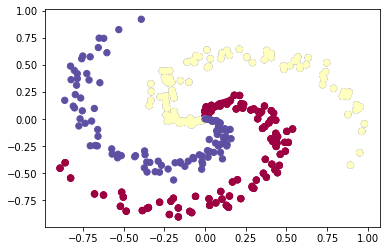

In [11]:
X,y=spiral_data_gen()

In [12]:
W_softmax=SoftmaxClassiferWithNegLog(X,y)

Softmax training starts.
Epoch 0: Cost:1.108307156910156
Epoch 500: Cost:0.8980691171015343
Epoch 1000: Cost:0.8980691242695709
Epoch 1500: Cost:0.8980691242564671
Epoch 2000: Cost:0.89806912424461
Epoch 2500: Cost:0.8980691242338814
Epoch 3000: Cost:0.8980691242241738
Epoch 3500: Cost:0.89806912421539
Epoch 4000: Cost:0.8980691242074421
Epoch 4500: Cost:0.8980691242002505
training accuracy: 0.54
              precision    recall  f1-score   support

           0       0.51      0.53      0.52       100
           1       0.59      0.60      0.60       100
           2       0.50      0.48      0.49       100

    accuracy                           0.54       300
   macro avg       0.54      0.54      0.54       300
weighted avg       0.54      0.54      0.54       300



In [13]:
W_max_margin=MaximumMarginClassifier(X,y)

MaximumMarginClassifier training starts
training accuracy: 0.53
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       100
           1       0.58      0.60      0.59       100
           2       0.53      0.48      0.50       100

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.53       300
weighted avg       0.53      0.53      0.53       300



In [14]:
def plot_decision_boundries(X,y,W):
    """
    X.shape(N,D)
    y.shape(N,)
    K=number of class
    """
    
    WW=W[:,:2]
    b=W[:,2].reshape(3,1)
    
    
    predicted_probabilities=softmax(WW.dot(X.T)+b).T
    # evaluate training set accuracy
    #scores =softmax(WW.dot(X.T)+b).T
    predicted_class = np.argmax(predicted_probabilities, axis=1)
    print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))


    WW=WW.T
    b=b.T

    # plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], WW) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #fig.savefig('spiral_linear.png')

training accuracy: 0.53


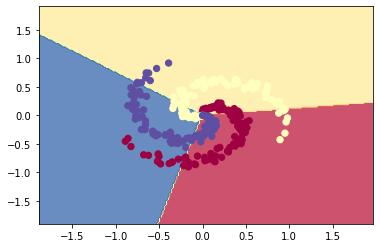

In [15]:
plot_decision_boundries(X,y,W_max_margin)

training accuracy: 0.54


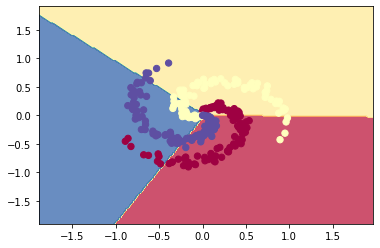

In [16]:
plot_decision_boundries(X,y,W_softmax)